In [18]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import src.edge_constructors as edge
import src.clustering as clu
import src.metrics_fr as fr
import src.utils as utils

# Thesis Evaluation

## Helper Functions

In [2]:
def load_data(filepath, n=None):
    assert filepath[-4:] == ".csv", "Must be a .csv file"
    data = pd.read_csv(filepath)
    if n:
        data = data.head(n)

    attrs = {
        "titles": data["title"].tolist(),
        "text": data["text"].tolist(),
        "tags": data["tags"].apply(ast.literal_eval).tolist(),
        "ids": data.index.tolist()
    }

    if "simplified_tags" in data.columns:
        attrs["simplified_tags"] = data["simplified_tags"].apply(ast.literal_eval).tolist()

    return attrs

def load_embeddings(dataset_name, model_names):
    embeddings = []
    for name in model_names:
        embeddings.append(utils.load_from_pickle(f"embeddings/{dataset_name}_{name}_n10000.pickle"))
    return embeddings

## Data: interview_prep.csv

In [3]:
data_name = "interview_prep"
data = load_data(f"data/{data_name}.csv")

### Embedding and Similarity Scores

In [4]:
df1 = fr.get_embedding_similarity_metrics_per_dataset("interview_prep", data["tags"],
                                             ["minilm", "mpnet", "nomic", "bert", "specter", "word2vec"],
                                             ["mean"])
df1.to_csv("analysis/metric1_interview.csv")
df1.head(10)

,data_source,embedding_model,agg_method,metric_name,metric,between_all_nodes,between_shared_tags
0,interview_prep,minilm,mean,cosine,mean,0.684910,0.706979
1,interview_prep,minilm,mean,cosine,median,0.674775,0.715765
2,interview_prep,minilm,mean,cosine,std_dev,0.069721,0.070315
3,interview_prep,minilm,mean,soft_cosine,mean,0.641387,0.656642
4,interview_prep,minilm,mean,soft_cosine,median,0.644162,0.661419
5,interview_prep,minilm,mean,soft_cosine,std_dev,0.126290,0.134193
6,interview_prep,minilm,mean,euclidean,mean,0.537721,0.561980
7,interview_prep,minilm,mean,euclidean,median,0.521811,0.566406
8,interview_prep,minilm,mean,euclidean,std_dev,0.075639,0.077599
0,interview_prep,mpnet,mean,cosine,mean,0.707133,0.725702


### Cluster Purity, Homogeneity, and Completeness

In [ ]:
k_values = [1, 2, 5, 10, 15, 20]
clustering_methods = {
    **{f"kmeans{k}": lambda x, k=k: clu.kmeans(x, k) for k in k_values},
    **{f"dbscan_eps{eps}_min{min_samples}": lambda x, eps=eps, min_samples=min_samples: clu.dbscan(x, eps=eps, min_samples=min_samples) for eps in [0.1, 0.3, 0.5, 0.7, 1.0] for min_samples in [3, 5, 10, 15]},
    **{f"gmm{n_components}": lambda x, n_components=n_components: clu.gmm(x, n_components) for n_components in k_values},
    **{f"birch{k}": lambda x, k=k: clu.birch(x, k) for k in k_values}
}

df2 = fr.compare_cluster_metrics("interview_prep",
                                    ["minilm", "mpnet", "nomic", "bert", "specter", "word2vec"],
                                    ["mean"],
                                    clustering_methods, data["ids"], data["tags"], k=2)
df2.to_csv("analysis/metric2_interview.csv")
df2

### Edge Assignment Evaluation: Tag Connectivity and Degree of Separation

In [6]:
k_values = [1, 2, 5, 50]
clustering_methods = {
    **{f"kmeans{k}": lambda x, k=k: clu.kmeans(x, k) for k in k_values},
    **{f"dbscan_eps{eps}_min{min_samples}": lambda x, eps=eps, min_samples=min_samples: clu.dbscan(x, eps=eps, min_samples=min_samples) for eps in [0.1, 0.3, 0.5, 0.7, 1.0] for min_samples in [3, 5, 10, 15]},
    **{f"gmm{n_components}": lambda x, n_components=n_components: clu.gmm(x, n_components) for n_components in k_values},
    **{f"birch{k}": lambda x, k=k: clu.birch(x, k) for k in k_values}
}

edge_connector_methods = {
    "random_edges": lambda sim_mat, document_ids: edge.random_edges(sim_mat, document_ids, num_edges_per_node=5),
    **{f"knn{k}": lambda sim_mat, document_ids, k=k: edge.knn(sim_mat, document_ids, k) for k in [3, 5, 10, 15]},
    **{f"knn_mst{k}": lambda sim_mat, document_ids, k=k: edge.knn_mst(sim_mat, document_ids, k) for k in [3, 5, 10, 15]},
    **{f"threshold_{threshold}": lambda sim_mat, document_ids, threshold=threshold: edge.threshold_based_edge_assignment(sim_mat, document_ids, threshold) for threshold in [0.3, 0.5, 0.7, 0.9]},
    **{f"mutual_knn{k}": lambda sim_mat, document_ids, k=k: edge.mutual_knn_edge_assignment(sim_mat, document_ids, k) for k in [3, 5, 10, 15]},
    **{f"spectral_clustering{n_clusters}": lambda sim_mat, document_ids, n_clusters=n_clusters: edge.spectral_clustering_edge_assignment(sim_mat, document_ids, n_clusters) for n_clusters in [2, 3, 5, 10]}
}

df3 = fr.compare_edge_assignment_metrics("interview_prep",
                                        ["minilm", "mpnet", "nomic", "bert", "specter", "word2vec"],
                                        ["mean"],
                                        clustering_methods,
                                        edge_connector_methods, data["ids"], data["tags"], data["titles"], max_depth=3)
df3.to_csv("analysis/metric3_interview.csv")
df3.head(10)

graphs/interview_prep_minilm_cosine_mean_random_edges_kmeans1
graphs/interview_prep_minilm_cosine_mean_random_edges_kmeans2
graphs/interview_prep_minilm_cosine_mean_random_edges_kmeans5
graphs/interview_prep_minilm_cosine_mean_random_edges_dbscan_eps0.1_min3
graphs/interview_prep_minilm_cosine_mean_random_edges_dbscan_eps0.1_min5
graphs/interview_prep_minilm_cosine_mean_random_edges_dbscan_eps0.1_min10
graphs/interview_prep_minilm_cosine_mean_random_edges_dbscan_eps0.1_min15
graphs/interview_prep_minilm_cosine_mean_random_edges_dbscan_eps0.3_min3
graphs/interview_prep_minilm_cosine_mean_random_edges_dbscan_eps0.3_min5
graphs/interview_prep_minilm_cosine_mean_random_edges_dbscan_eps0.3_min10
graphs/interview_prep_minilm_cosine_mean_random_edges_dbscan_eps0.3_min15
graphs/interview_prep_minilm_cosine_mean_random_edges_dbscan_eps0.5_min3
graphs/interview_prep_minilm_cosine_mean_random_edges_dbscan_eps0.5_min5
graphs/interview_prep_minilm_cosine_mean_random_edges_dbscan_eps0.5_min10
graphs

## Data: Medium (n=2000)

In [3]:
data_name = "medium1k"
data = load_data(f"data/{data_name}.csv", n=2000)
ids = data["ids"]
titles = data["titles"]
tags = data["simplified_tags"]

### Embedding and Similarity Scores

#### Processing

In [11]:
df_minilm = fr.get_embedding_similarity_metrics_per_dataset("medium1k", tags,
                                             ["minilm"],
                                             ["mean"])

df_minilm.to_csv("analysis/metric1_medium1k_minilm.csv")
df_minilm.head(10)

,data_source,embedding_model,agg_method,metric_name,metric,between_all_nodes,between_shared_tags
0,medium1k,minilm,mean,cosine,mean,0.590242,0.617690
1,medium1k,minilm,mean,cosine,median,0.576827,0.606977
2,medium1k,minilm,mean,cosine,std_dev,0.073052,0.081245
3,medium1k,minilm,mean,soft_cosine,mean,0.583869,0.606259
4,medium1k,minilm,mean,soft_cosine,median,0.581067,0.604366
5,medium1k,minilm,mean,soft_cosine,std_dev,0.097065,0.103766
6,medium1k,minilm,mean,euclidean,mean,0.445565,0.471878
7,medium1k,minilm,mean,euclidean,median,0.428979,0.455643
8,medium1k,minilm,mean,euclidean,std_dev,0.069450,0.080446


In [5]:
df_mpnet = fr.get_embedding_similarity_metrics_per_dataset("medium1k", tags,
                                             ["mpnet"],
                                             ["mean"])

df_mpnet.to_csv("analysis/metric1_medium1k_mpnet.csv")
df_mpnet.head(10)

,data_source,embedding_model,agg_method,metric_name,metric,between_all_nodes,between_shared_tags
0,medium1k,mpnet,mean,cosine,mean,0.571134,0.599069
1,medium1k,mpnet,mean,cosine,median,0.557227,0.587110
2,medium1k,mpnet,mean,cosine,std_dev,0.065349,0.074976
3,medium1k,mpnet,mean,soft_cosine,mean,0.555294,0.583376
4,medium1k,mpnet,mean,soft_cosine,median,0.550332,0.578490
5,medium1k,mpnet,mean,soft_cosine,std_dev,0.083362,0.090763
6,medium1k,mpnet,mean,euclidean,mean,0.427934,0.453748
7,medium1k,mpnet,mean,euclidean,median,0.412489,0.437893
8,medium1k,mpnet,mean,euclidean,std_dev,0.060250,0.072099


In [6]:
df_nomic = fr.get_embedding_similarity_metrics_per_dataset("medium1k", tags,
                                             ["nomic"],
                                             ["mean"])

df_nomic.to_csv("analysis/metric1_medium1k_nomic.csv")
df_nomic.head(10)

,data_source,embedding_model,agg_method,metric_name,metric,between_all_nodes,between_shared_tags
0,medium1k,nomic,mean,cosine,mean,0.781036,0.796974
1,medium1k,nomic,mean,cosine,median,0.779127,0.795989
2,medium1k,nomic,mean,cosine,std_dev,0.041341,0.043124
3,medium1k,nomic,mean,soft_cosine,mean,0.810484,0.822719
4,medium1k,nomic,mean,soft_cosine,median,0.813769,0.826244
5,medium1k,nomic,mean,soft_cosine,std_dev,0.048140,0.048397
6,medium1k,nomic,mean,euclidean,mean,0.647597,0.668766
7,medium1k,nomic,mean,euclidean,median,0.642913,0.664964
8,medium1k,nomic,mean,euclidean,std_dev,0.054165,0.058038


In [7]:
df_bert = fr.get_embedding_similarity_metrics_per_dataset("medium1k", tags,
                                             ["bert"],
                                             ["mean"])

df_bert.to_csv("analysis/metric1_medium1k_bert.csv")
df_bert.head(10)

,data_source,embedding_model,agg_method,metric_name,metric,between_all_nodes,between_shared_tags
0,medium1k,bert,mean,cosine,mean,0.928098,0.935476
1,medium1k,bert,mean,cosine,median,0.933778,0.941286
2,medium1k,bert,mean,cosine,std_dev,0.031001,0.029073
3,medium1k,bert,mean,soft_cosine,mean,0.993880,0.994453
4,medium1k,bert,mean,soft_cosine,median,0.994650,0.995230
5,medium1k,bert,mean,soft_cosine,std_dev,0.003455,0.003273
6,medium1k,bert,mean,euclidean,mean,0.867677,0.880378
7,medium1k,bert,mean,euclidean,median,0.875953,0.889204
8,medium1k,bert,mean,euclidean,std_dev,0.051667,0.049165


In [8]:
df_specter = fr.get_embedding_similarity_metrics_per_dataset("medium1k", tags,
                                             ["specter"],
                                             ["mean"])

df_specter.to_csv("analysis/metric1_medium1k_specter.csv")
df_specter.head(10)

,data_source,embedding_model,agg_method,metric_name,metric,between_all_nodes,between_shared_tags
0,medium1k,specter,mean,cosine,mean,0.929333,0.936662
1,medium1k,specter,mean,cosine,median,0.932402,0.940384
2,medium1k,specter,mean,cosine,std_dev,0.028182,0.027408
3,medium1k,specter,mean,soft_cosine,mean,0.979847,0.981411
4,medium1k,specter,mean,soft_cosine,median,0.981783,0.983331
5,medium1k,specter,mean,soft_cosine,std_dev,0.011299,0.010762
6,medium1k,specter,mean,euclidean,mean,0.869556,0.882320
7,medium1k,specter,mean,euclidean,median,0.873545,0.887602
8,medium1k,specter,mean,euclidean,std_dev,0.047796,0.047138


In [10]:
df_word2vec = fr.get_embedding_similarity_metrics_per_dataset("medium1k", tags,
                                             ["word2vec"],
                                             ["mean"])

df_word2vec.to_csv("analysis/metric1_medium1k_word2vec.csv")
df_word2vec.head(10)

,data_source,embedding_model,agg_method,metric_name,metric,between_all_nodes,between_shared_tags
0,medium1k,word2vec,mean,cosine,mean,0.929844,0.938316
1,medium1k,word2vec,mean,cosine,median,0.937774,0.946368
2,medium1k,word2vec,mean,cosine,std_dev,0.040045,0.037217
3,medium1k,word2vec,mean,soft_cosine,mean,0.947983,0.958764
4,medium1k,word2vec,mean,soft_cosine,median,0.975464,0.981225
5,medium1k,word2vec,mean,soft_cosine,std_dev,0.094845,0.079709
6,medium1k,word2vec,mean,euclidean,mean,0.900479,0.912150
7,medium1k,word2vec,mean,euclidean,median,0.914254,0.925894
8,medium1k,word2vec,mean,euclidean,std_dev,0.064321,0.059712


In [14]:
df_all = pd.concat([df_minilm, df_bert, df_mpnet, df_nomic, df_specter, df_word2vec])
df_all.to_csv("analysis/metric1_medium1k.csv")

#### Analysis

In [17]:
metric1_df = pd.read_csv("analysis/metric1_medium1k.csv")

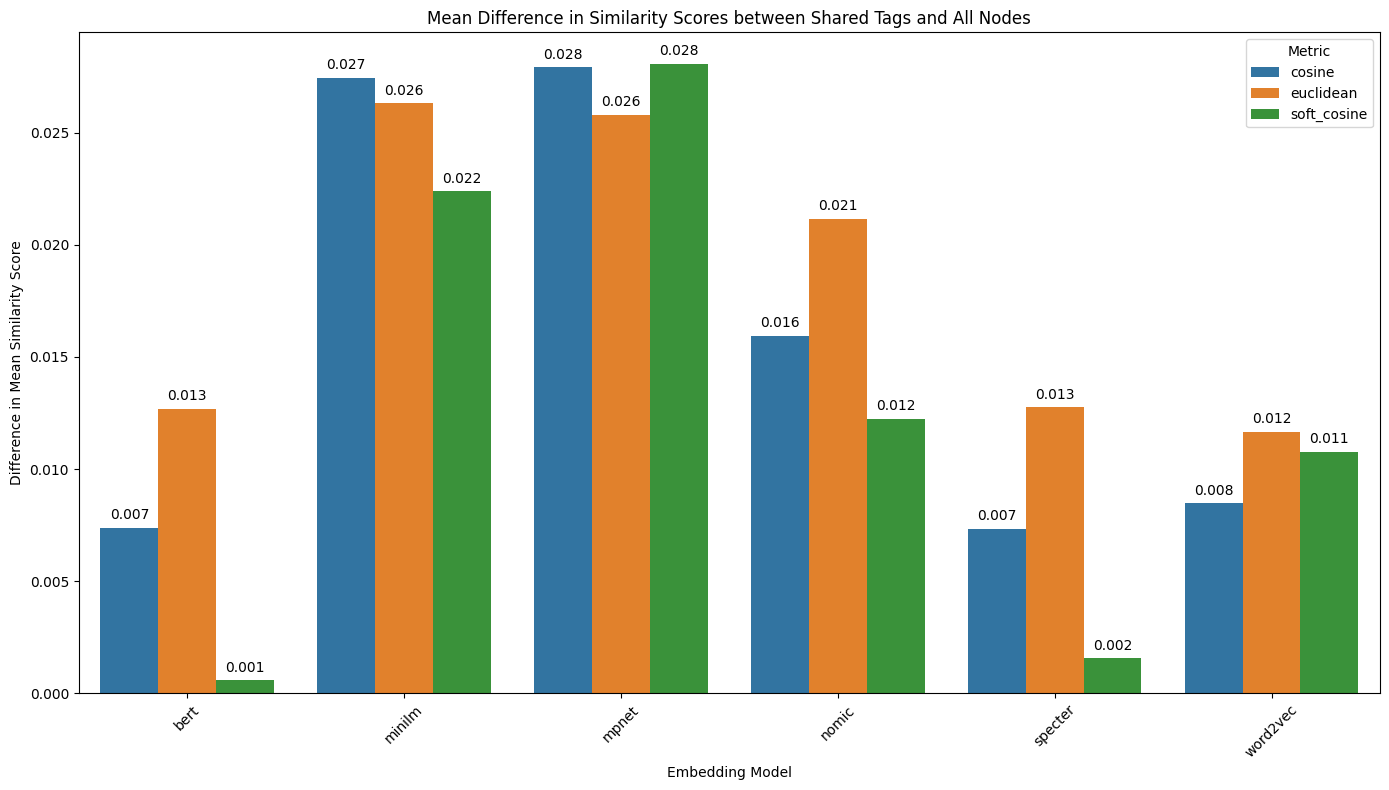

In [40]:
metric1_df['difference'] = metric1_df['between_shared_tags'] - metric1_df['between_all_nodes']
pivot_data = metric1_df.pivot_table(index=['embedding_model', 'metric_name'], columns='metric', values='difference').reset_index()

plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='embedding_model', y='mean', hue='metric_name', data=pivot_data)

for p in bar_plot.patches:
    height = p.get_height()
    if height > 0:
        bar_plot.annotate(format(height, '.3f'), 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')

plt.title('Mean Difference in Similarity Scores between Shared Tags and All Nodes')
plt.xlabel('Embedding Model')
plt.ylabel('Difference in Mean Similarity Score')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

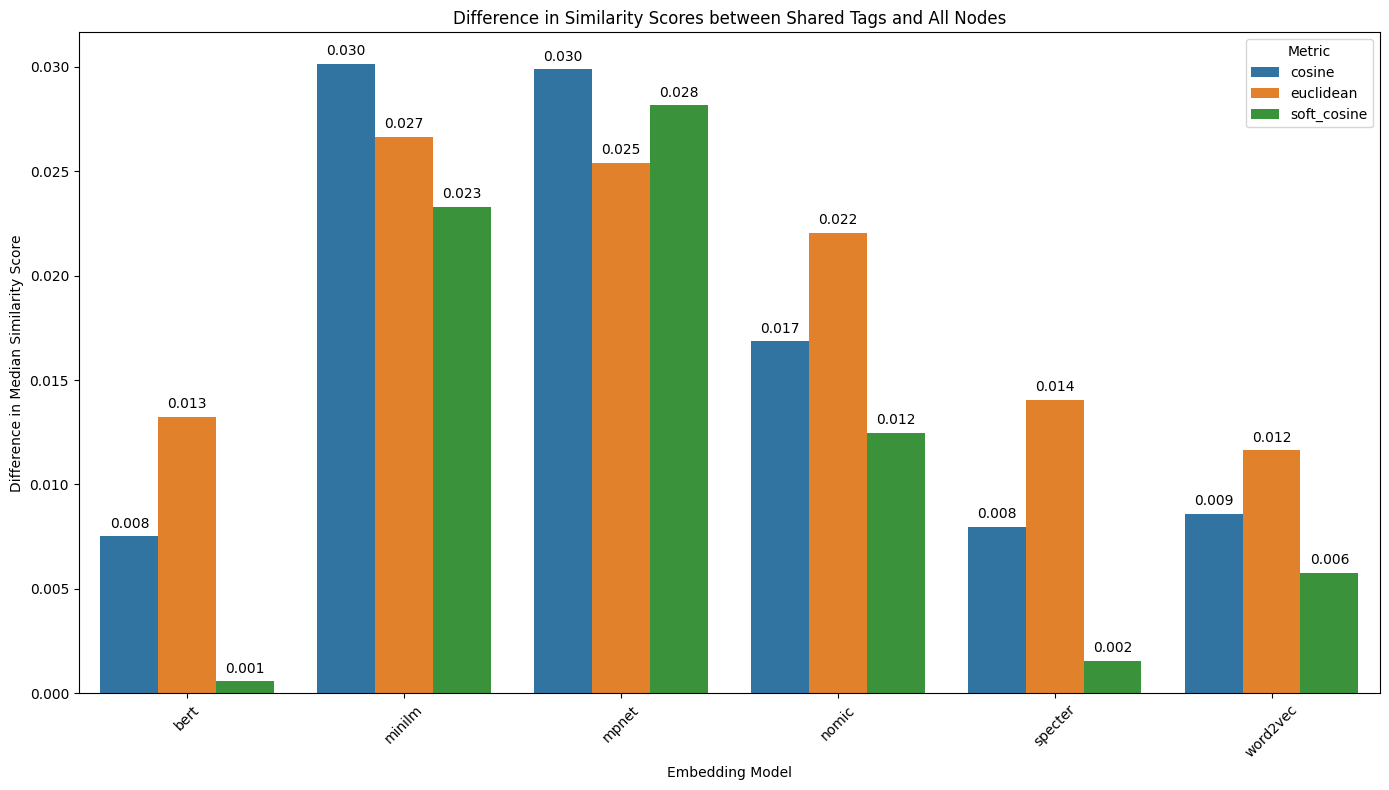

In [39]:
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='embedding_model', y='median', hue='metric_name', data=pivot_data)

for p in bar_plot.patches:
    height = p.get_height()
    if height > 0:
        bar_plot.annotate(format(height, '.3f'), 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')

plt.title('Median Difference in Similarity Scores between Shared Tags and All Nodes')
plt.xlabel('Embedding Model')
plt.ylabel('Difference in Median Similarity Score')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:
def color_map(val):
    if isinstance(val, (int, float)):
        if val < 0.01:
            return 'background-color: #961418'
        elif val < 0.02:
            return 'background-color: #98a11a'
        else:
            return 'background-color: #105e11'
    else:
        return ''

# Apply the color map to the DataFrame
styled_table = pivot_data[["embedding_model", "metric_name", "mean", "median"]].style.applymap(color_map)

# Display the styled table
styled_table

/var/folders/16/w2tjk8ms4t322jq3ms1b49rh0000gn/T/ipykernel_80223/4024943012.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = pivot_data[["embedding_model", "metric_name", "mean", "median"]].style.applymap(color_map)


metric,embedding_model,metric_name,mean,median
0,bert,cosine,0.007378,0.007507
1,bert,euclidean,0.012700,0.013252
2,bert,soft_cosine,0.000573,0.000580
3,minilm,cosine,0.027448,0.030150
4,minilm,euclidean,0.026312,0.026663
5,minilm,soft_cosine,0.022390,0.023300
6,mpnet,cosine,0.027936,0.029883
7,mpnet,euclidean,0.025815,0.025404
8,mpnet,soft_cosine,0.028081,0.028158
9,nomic,cosine,0.015938,0.016861


### Cluster Purity, Homogeneity, and Completeness

#### Processing

In [24]:
k_values = [1, 2, 5, 10, 15, 50, 100]
clustering_methods = {
    **{f"kmeans{k}": lambda x, k=k: clu.kmeans(x, k) for k in k_values},
    **{f"dbscan_eps{eps}_min{min_samples}": lambda x, eps=eps, min_samples=min_samples: clu.dbscan(x, eps=eps, min_samples=min_samples) for eps in [0.1, 0.3, 0.5, 0.7, 1.0] for min_samples in [3, 5, 10, 15]},
    **{f"gmm{n_components}": lambda x, n_components=n_components: clu.gmm(x, n_components) for n_components in k_values},
    **{f"birch{k}": lambda x, k=k: clu.birch(x, k) for k in k_values}
}

# df2 = fr.compare_cluster_metrics("medium1k",
#                                     ["minilm", "mpnet", "nomic", "bert", "specter", "word2vec"],
#                                     ["mean"],
#                                     clustering_methods,
#                                     ids, tags, k=2)

# df2.to_csv("analysis/metric2_medium1k.csv")
# df2.head(10)

In [25]:
df_minilm2 = fr.compare_cluster_metrics("medium1k",
                                    ["minilm"],
                                    ["mean"],
                                    clustering_methods,
                                    ids, tags, k=15)

df_minilm2.to_csv("analysis/metric2_medium1k_minilm.csv")

In [26]:
df_mpnet2 = fr.compare_cluster_metrics("medium1k",
                                    ["mpnet"],
                                    ["mean"],
                                    clustering_methods,
                                    ids, tags, k=15)

df_mpnet2.to_csv("analysis/metric2_medium1k_minilm.csv")

In [27]:
df_specter2 = fr.compare_cluster_metrics("medium1k",
                                    ["specter"],
                                    ["mean"],
                                    clustering_methods,
                                    ids, tags, k=15)


df_specter2.to_csv("analysis/metric2_medium1k_specter.csv")

Error: Found array with 1 sample(s) (shape=(1, 768)) while a minimum of 2 is required by AgglomerativeClustering.
Skipping specter, mean, birch1 due to insufficient samples


/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (2). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (15). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: Converge

In [28]:
df_word2vec2 = fr.compare_cluster_metrics("medium1k",
                                    ["word2vec"],
                                    ["mean"],
                                    clustering_methods,
                                    ids, tags, k=15)


df_word2vec2.to_csv("analysis/metric2_medium1k_word2vec.csv")

Error: Found array with 1 sample(s) (shape=(1, 300)) while a minimum of 2 is required by AgglomerativeClustering.
Skipping word2vec, mean, birch1 due to insufficient samples


/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (2). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (15). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: Converge

In [29]:
df_bert2 = fr.compare_cluster_metrics("medium1k",
                                    ["bert"],
                                    ["mean"],
                                    clustering_methods,
                                    ids, tags, k=15)


df_bert2.to_csv("analysis/metric2_medium1k_bert.csv")

Error: Found array with 1 sample(s) (shape=(1, 768)) while a minimum of 2 is required by AgglomerativeClustering.
Skipping bert, mean, birch1 due to insufficient samples


/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (2). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (15). Decrease the threshold.
  warnings.warn(
/Users/erikluu/Desktop/LociNet-main/.venv/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: Converge

In [30]:
df_nomic2 = fr.compare_cluster_metrics("medium1k",
                                    ["nomic"],
                                    ["mean"],
                                    clustering_methods,
                                    ids, tags, k=15)


df_nomic2.to_csv("analysis/metric2_medium1k_nomic.csv")

In [33]:
df_all2 = pd.concat([df_bert2, df_minilm2, df_mpnet2, df_nomic2, df_specter2, df_word2vec2])
df_all2.to_csv("analysis/metric2_medium1k.csv")

#### Analysis

In [73]:
df_all2 = pd.read_csv("analysis/metric2_medium1k.csv")
df_all2 = df_all2[df_all2["embedding_model"] != "bert"]

,dataset,embedding_model,agg_method,clusterer,homogeneity,completeness,tag_concentration_purity,cluster_tag_purity
0,medium1k,bert,mean,kmeans1,0.000,1.000,"{'Technology': 0.41, 'Art': 0.26, 'Writing': 0...","{'Technology': 0.153, 'Art': 0.097, 'Writing':..."
1,medium1k,bert,mean,kmeans2,0.036,0.338,"{'Technology': 0.269, 'Art': 0.312, 'Writing':...","{'Technology': 0.08, 'Art': 0.092, 'Writing': ..."
2,medium1k,bert,mean,kmeans5,0.126,0.264,"{'Technology': 0.972, 'Art': 0.419, 'Writing':...","{'Technology': 0.059, 'Art': 0.04, 'Writing': ..."
3,medium1k,bert,mean,kmeans10,0.140,0.207,"{'Technology': 0.707, 'Art': 0.432, 'Writing':...","{'Technology': 0.03, 'Art': 0.027, 'Writing': ..."
4,medium1k,bert,mean,kmeans15,0.162,0.203,"{'Technology': 0.961, 'Art': 0.487, 'Writing':...","{'Technology': 0.023, 'Art': 0.025, 'Writing':..."


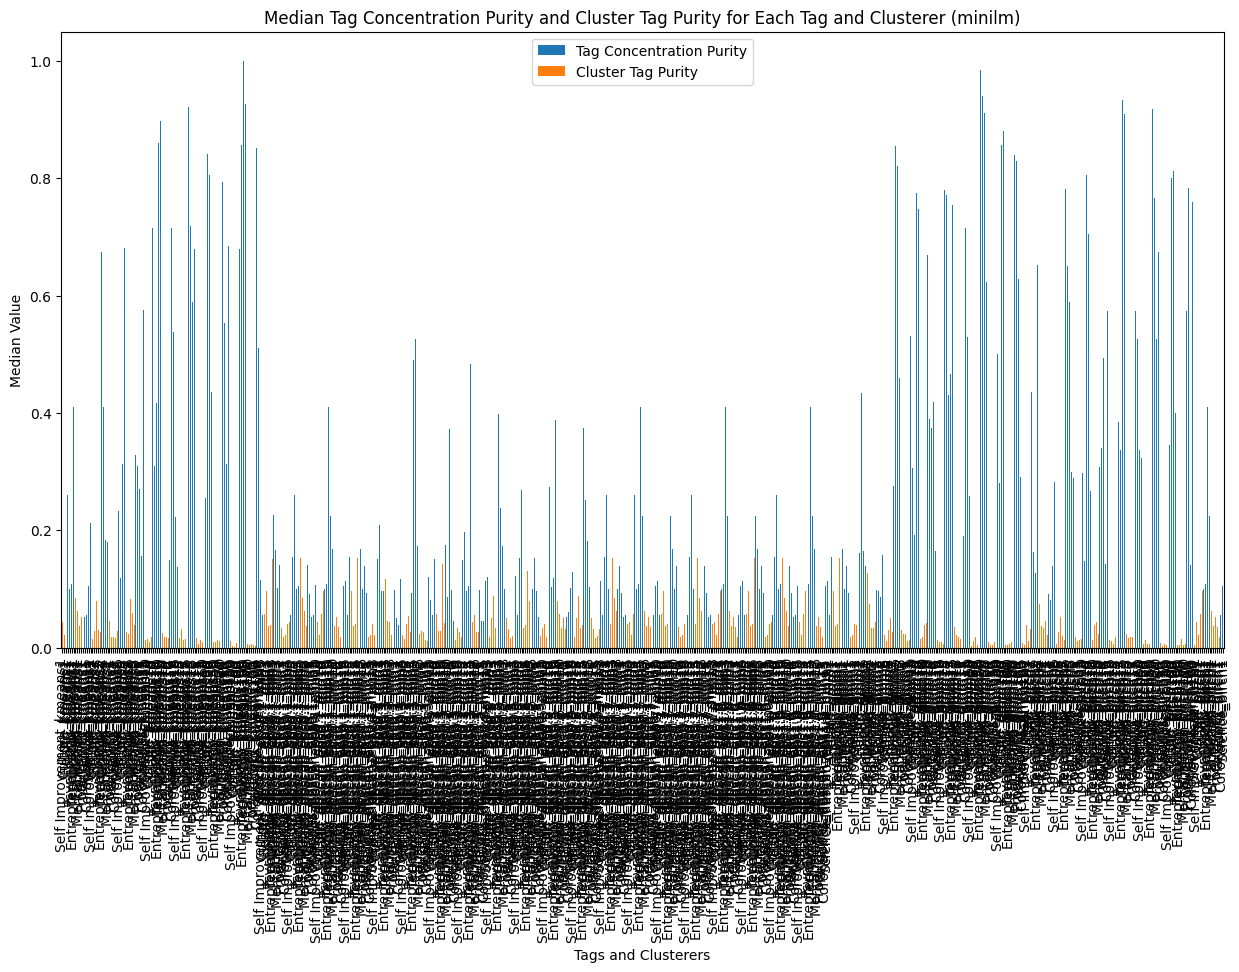

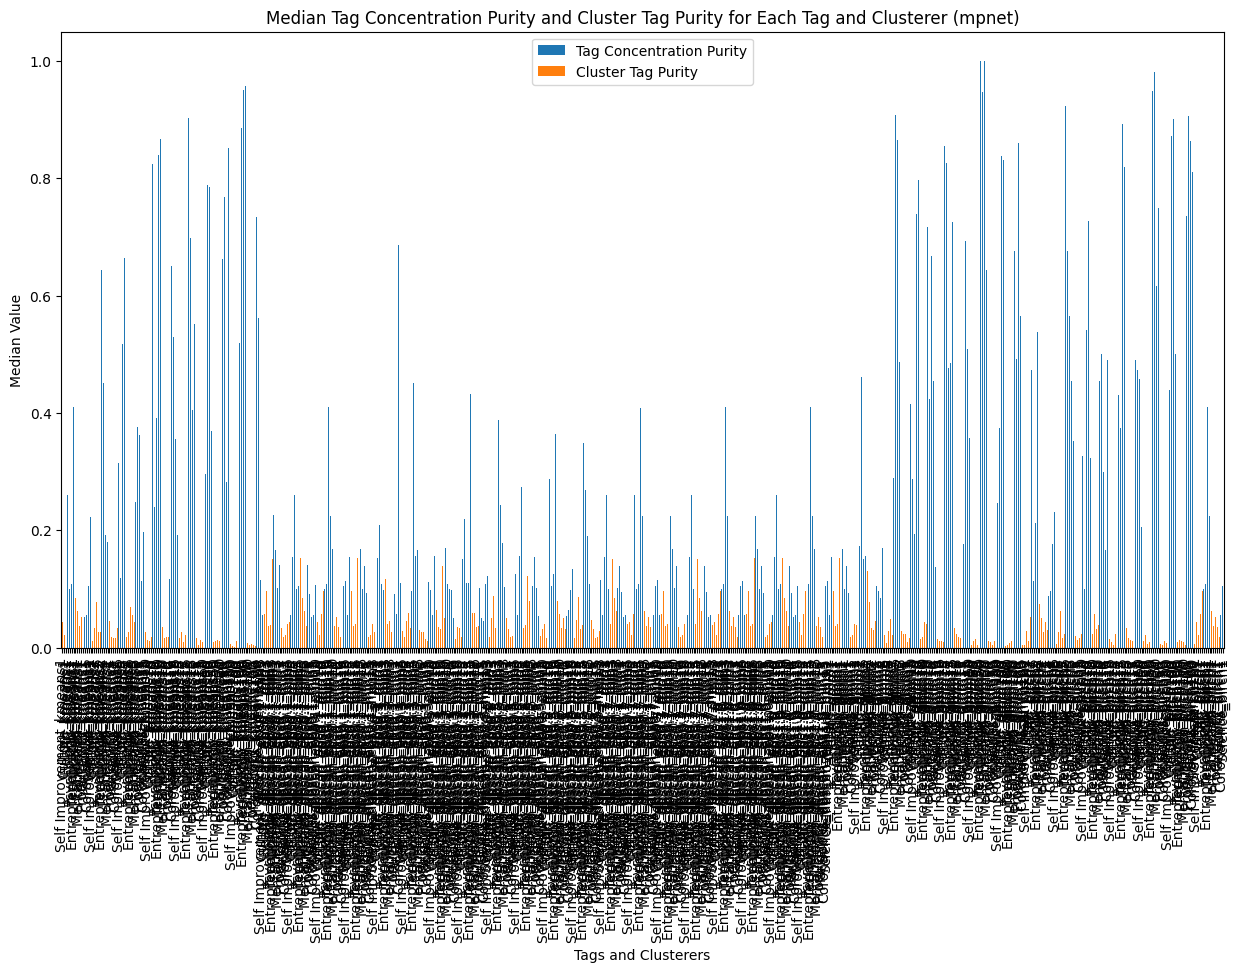

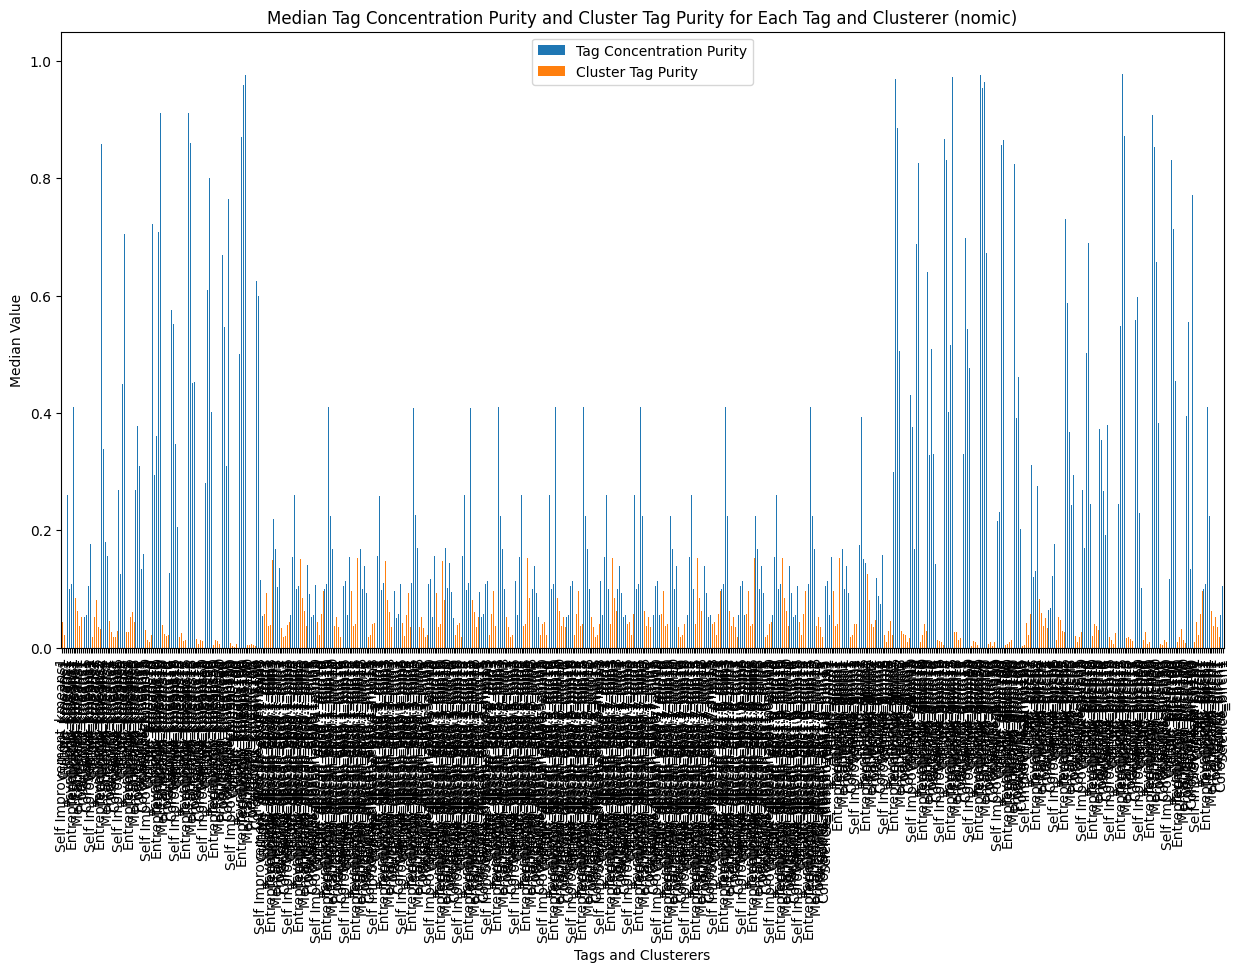

In [100]:
df = df_all.dropna()

tag_concentration_purity = list(df['tag_concentration_purity'])
cluster_tag_purity = list(df['cluster_tag_purity'])

# Extract unique tags from dictionaries
tags = set(tag for d in tag_concentration_purity for tag in d.keys())

# Function to calculate median values for each model and clusterer
def calculate_median_values(df, model_name):
    median_values = pd.DataFrame(columns=['Tag Concentration Purity', 'Cluster Tag Purity'])
    clusterers = df['clusterer'].unique()
    for clusterer in clusterers:
        clusterer_df = df[(df['embedding_model'] == model_name) & (df['clusterer'] == clusterer)]
        tag_concentration_purity = list(clusterer_df['tag_concentration_purity'])
        cluster_tag_purity = list(clusterer_df['cluster_tag_purity'])
        for tag in tags:
            tag_concentration_values = [d[tag] for d in tag_concentration_purity if tag in d]
            cluster_tag_values = [d[tag] for d in cluster_tag_purity if tag in d]
            median_values.loc[f'{tag}_{clusterer}', 'Tag Concentration Purity'] = pd.Series(tag_concentration_values).median()
            median_values.loc[f'{tag}_{clusterer}', 'Cluster Tag Purity'] = pd.Series(cluster_tag_values).median()
    return median_values

# Calculate median values for each model
minilm_median_values = calculate_median_values(df, 'minilm')
mpnet_median_values = calculate_median_values(df, 'mpnet')
nomic_median_values = calculate_median_values(df, 'nomic')

# Plot the median values for each tag and each model
def plot_median_values(median_values, model_name):
    median_values.plot(kind='bar', figsize=(15, 8))
    plt.xlabel('Tags and Clusterers')
    plt.ylabel('Median Value')
    plt.title(f'Median Tag Concentration Purity and Cluster Tag Purity for Each Tag and Clusterer ({model_name})')
    plt.xticks(rotation=90)
    plt.show()

plot_median_values(minilm_median_values, 'minilm')
plot_median_values(mpnet_median_values, 'mpnet')
plot_median_values(nomic_median_values, 'nomic')

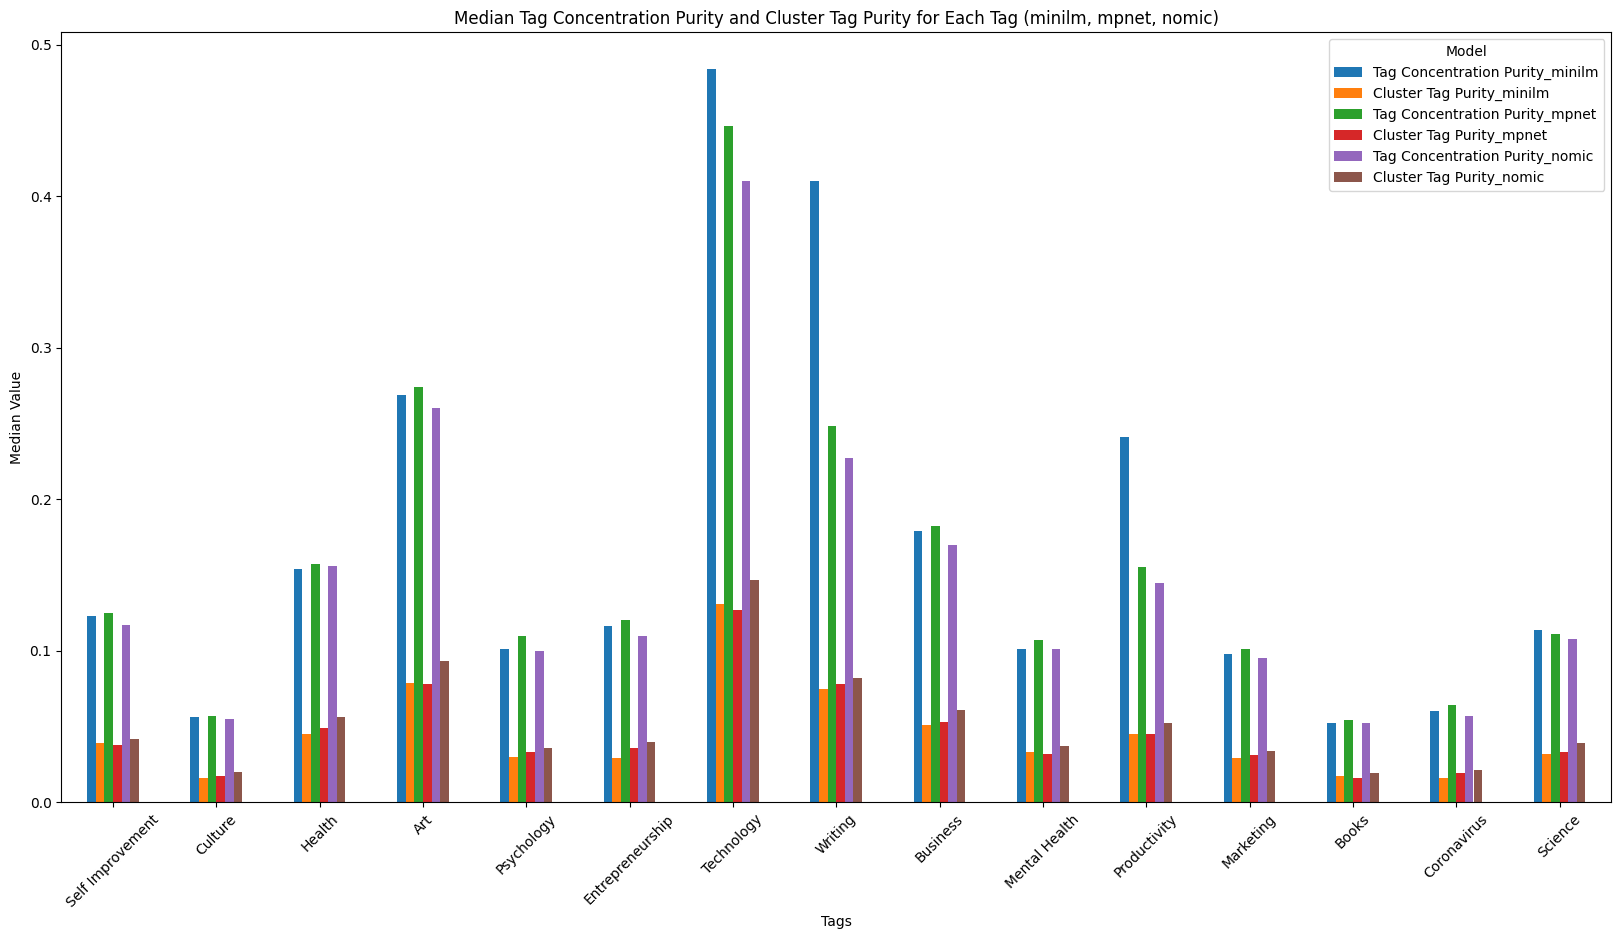

In [114]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Load the data
df = df.dropna()

# Extract unique tags from dictionaries
tags = set(tag for d in df['tag_concentration_purity'] for tag in d.keys())

# Function to calculate median values for each model
def calculate_median_values(df, model_name):
    model_df = df[df['embedding_model'] == model_name]
    tag_concentration_purity = list(model_df['tag_concentration_purity'])
    cluster_tag_purity = list(model_df['cluster_tag_purity'])
    median_values = pd.DataFrame(columns=['Tag Concentration Purity', 'Cluster Tag Purity'])
    for tag in tags:
        tag_concentration_values = [d[tag] for d in tag_concentration_purity if tag in d]
        cluster_tag_values = [d[tag] for d in cluster_tag_purity if tag in d]
        median_values.loc[tag, 'Tag Concentration Purity'] = pd.Series(tag_concentration_values).median()
        median_values.loc[tag, 'Cluster Tag Purity'] = pd.Series(cluster_tag_values).median()
    return median_values

# Calculate median values for each model
minilm_median_values = calculate_median_values(df, 'minilm')
mpnet_median_values = calculate_median_values(df, 'mpnet')
nomic_median_values = calculate_median_values(df, 'nomic')

# Combine the median values into a single DataFrame
combined_median_values = pd.concat([minilm_median_values.add_suffix('_minilm'),
                                    mpnet_median_values.add_suffix('_mpnet'),
                                    nomic_median_values.add_suffix('_nomic')],
                                   axis=1)

# Plot the combined median values
combined_median_values.plot(kind='bar', figsize=(20, 10))
plt.xlabel('Tags')
plt.ylabel('Median Value')
plt.title('Median Tag Concentration Purity and Cluster Tag Purity for Each Tag (minilm, mpnet, nomic)')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.show()


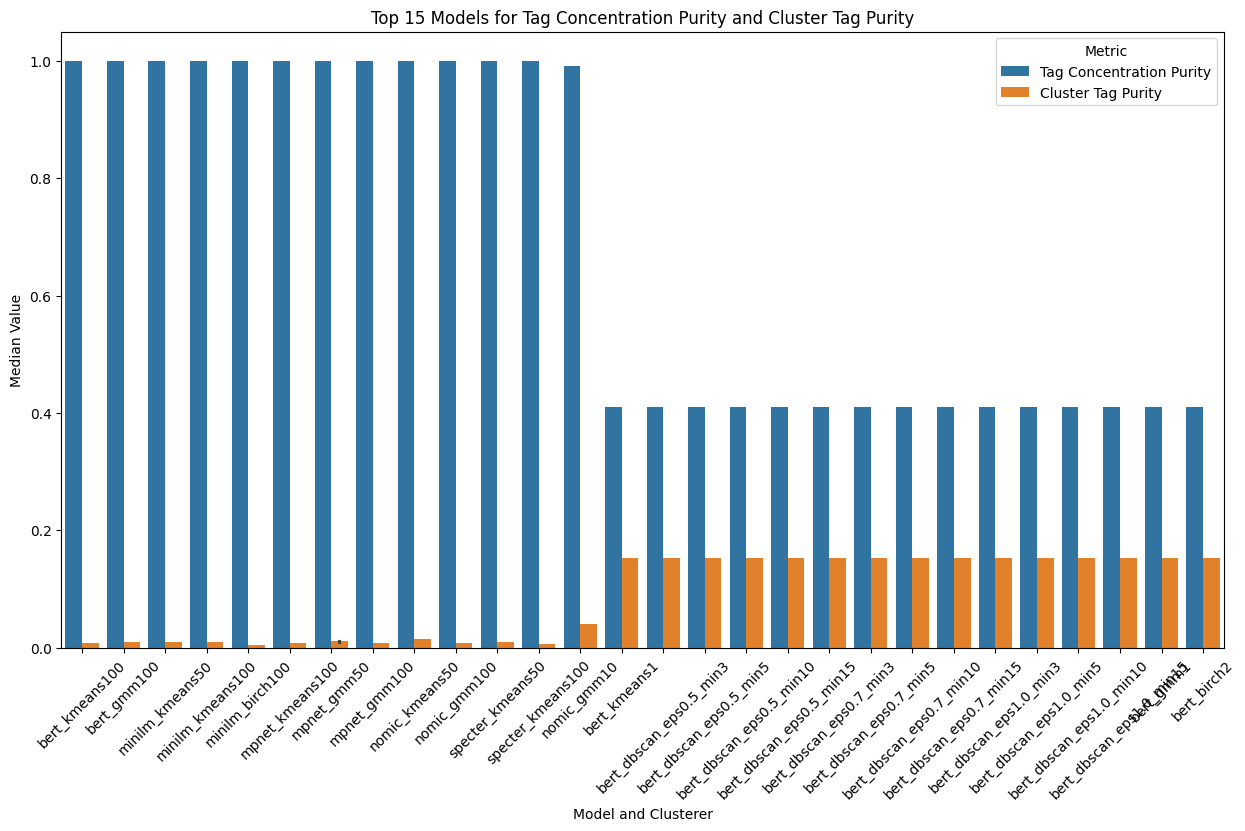

Top 15 models for Tag Concentration Purity:
        Model_Clusterer         Tag  Tag Concentration Purity
96       bert_kmeans100  Technology                     1.000
501         bert_gmm100  Technology                     1.000
696     minilm_kmeans50  Technology                     1.000
711    minilm_kmeans100  Technology                     1.000
1206    minilm_birch100  Technology                     1.000
1208    minilm_birch100    Business                     1.000
1328    mpnet_kmeans100    Business                     1.000
1716        mpnet_gmm50  Technology                     1.000
1718        mpnet_gmm50    Business                     1.000
1731       mpnet_gmm100  Technology                     1.000
1926     nomic_kmeans50  Technology                     1.000
2348       nomic_gmm100    Business                     1.000
2541   specter_kmeans50  Technology                     1.000
2556  specter_kmeans100  Technology                     1.000
2301        nomic_gmm10  T

In [110]:
df = df.dropna()

# Extract lists of dictionaries
tag_concentration_purity = list(df['tag_concentration_purity'])
cluster_tag_purity = list(df['cluster_tag_purity'])

# Extract unique tags from dictionaries
tags = set(tag for d in tag_concentration_purity for tag in d.keys())

# Function to calculate median values for each model and clusterer
def calculate_median_values(df):
    median_values = []
    models = df['embedding_model'].unique()
    clusterers = df['clusterer'].unique()
    for model in models:
        for clusterer in clusterers:
            subset_df = df[(df['embedding_model'] == model) & (df['clusterer'] == clusterer)]
            tag_concentration_purity = list(subset_df['tag_concentration_purity'])
            cluster_tag_purity = list(subset_df['cluster_tag_purity'])
            for tag in tags:
                tag_concentration_values = [d[tag] for d in tag_concentration_purity if tag in d]
                cluster_tag_values = [d[tag] for d in cluster_tag_purity if tag in d]
                median_tag_concentration = pd.Series(tag_concentration_values).median()
                median_cluster_tag = pd.Series(cluster_tag_values).median()
                median_values.append({'Model_Clusterer': f'{model}_{clusterer}',
                                      'Tag': tag,
                                      'Tag Concentration Purity': median_tag_concentration,
                                      'Cluster Tag Purity': median_cluster_tag})
    return pd.DataFrame(median_values)

# Calculate median values
median_values = calculate_median_values(df)

# Get top 10 models for tag concentration and cluster tag purity
top_tag_concentration = median_values.nlargest(15, 'Tag Concentration Purity')
top_cluster_tag_purity = median_values.nlargest(15, 'Cluster Tag Purity')

# Combine top models for tag concentration and cluster tag purity
top_models = pd.concat([top_tag_concentration, top_cluster_tag_purity]).drop_duplicates().reset_index(drop=True)

# Reshape data for side-by-side bar plots
top_models_melted = top_models.melt(id_vars=['Model_Clusterer', 'Tag'], 
                                    value_vars=['Tag Concentration Purity', 'Cluster Tag Purity'], 
                                    var_name='Metric', 
                                    value_name='Value')

# Plot the top models
plt.figure(figsize=(15, 8))
sns.barplot(x='Model_Clusterer', y='Value', hue='Metric', data=top_models_melted)
plt.xlabel('Model and Clusterer')
plt.ylabel('Median Value')
plt.title('Top 15 Models for Tag Concentration Purity and Cluster Tag Purity')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.show()

print("Top 15 models for Tag Concentration Purity:")
print(top_tag_concentration[['Model_Clusterer', 'Tag', 'Tag Concentration Purity']])
print("\nTop 15 models for Cluster Tag Purity:")
print(top_cluster_tag_purity[['Model_Clusterer', 'Tag', 'Cluster Tag Purity']])

top_tags_concentration = top_tag_concentration['Tag'].value_counts().index.tolist()
top_tags_purity = top_cluster_tag_purity['Tag'].value_counts().index.tolist()
top_tags = set(top_tags_concentration).union(set(top_tags_purity))

print(top_tags)

### Edge Assignment Evaluation: Tag Connectivity and Degree of Separation

In [ ]:
k_values = [1, 2, 5, 10, 15, 20, 30, 40, 50, 65, 80, 100, 120, 150]
threshold_values = [0.1, 0.3, 0.5, 0.7, 0.9]

clustering_methods = {
    **{f"kmeans{k}": lambda x, k=k: clu.kmeans(x, k) for k in k_values},
    **{f"dbscan_eps{eps}_min{min_samples}": lambda x, eps=eps, min_samples=min_samples: clu.dbscan(x, eps=eps, min_samples=min_samples) for eps in [0.1, 0.3, 0.5, 0.7, 1.0] for min_samples in [3, 5, 10, 15]},
    **{f"gmm{n_components}": lambda x, n_components=n_components: clu.gmm(x, n_components) for n_components in k_values},
    **{f"birch{k}": lambda x, k=k: clu.birch(x, k) for k in k_values}
}

edge_assignment_methods = {
    **{f"knn{k}": lambda sim_mat, ids, k=k: edge.knn(sim_mat, ids, k) for k in k_values},
    **{f"knn_mst{k}": lambda sim_mat, ids, k=k: edge.knn_mst(sim_mat, ids, k) for k in k_values},
    **{f"threshold{threshold}": lambda sim_mat, ids, threshold=threshold: edge.threshold_based_edge_assignment(sim_mat, ids, threshold) for threshold in threshold_values},
    **{f"mutual_knn{k}": lambda sim_mat, ids, k=k: edge.mutual_knn_edge_assignment(sim_mat, ids, k) for k in k_values},
    **{f"spectral{n_clusters}": lambda sim_mat, ids, n_clusters=n_clusters: edge.spectral_clustering_edge_assignment(sim_mat, ids, n_clusters) for n_clusters in k_values}
}

df3 = fr.compare_edge_assignment_metrics("interview_prep",
                                        ["minilm", "mpnet", "nomic"],
                                        ["mean"],
                                        clustering_methods,
                                        edge_assignment_methods,
                                        ids, tags, titles, max_depth=3)

df3.to_csv("analysis/metric3_medium1k.csv")
print(df3.head(10))

### Run

In [5]:
threshold_values = [0.1, 0.3, 0.5, 0.7, 0.9]
edge_assignment_methods = {
    **{f"random{k}": lambda x, k=k: edge.random_edges(x, ids, k) for k in k_values},
    **{f"knn{k}": lambda sim_mat, ids, k=k: edge.knn(sim_mat, ids, k) for k in k_values},
    **{f"knn_mst{k}": lambda sim_mat, ids, k=k: edge.knn_mst(sim_mat, ids, k) for k in k_values},
    **{f"threshold{threshold}": lambda sim_mat, ids, threshold=threshold: edge.threshold_based_edge_assignment(sim_mat, ids, threshold) for threshold in threshold_values},
    **{f"mutual_knn{k}": lambda sim_mat, ids, k=k: edge.mutual_knn_edge_assignment(sim_mat, ids, k) for k in k_values},
    **{f"spectral{n_clusters}": lambda sim_mat, ids, n_clusters=n_clusters: edge.spectral_clustering_edge_assignment(sim_mat, ids, n_clusters) for n_clusters in k_values}
}

In [14]:
df3 = fr.compare_edge_assignment_metrics("medium1k",
                                        ["minilm"],
                                        ["mean"],
                                        clustering_methods,
                                        edge_assignment_methods,
                                        ids, tags, titles, max_depth=8)

df3.to_csv("analysis/metric3_medium1k_minilm.csv")

KeyboardInterrupt: 

In [ ]:
df3 = fr.compare_edge_assignment_metrics("medium1k",
                                        ["specter"],
                                        ["mean"],
                                        clustering_methods,
                                        edge_assignment_methods,
                                        ids, tags, titles, max_depth=8)

df3.to_csv("analysis/metric3_medium1k_specter.csv")


: 

In [ ]:
df3 = fr.compare_edge_assignment_metrics("medium1k",
                                        ["word2vec"],
                                        ["mean"],
                                        clustering_methods,
                                        edge_assignment_methods,
                                        ids, tags, titles, max_depth=8)

df3.to_csv("analysis/metric3_medium1k_word2vec.csv")

: 

In [ ]:
df3 = fr.compare_edge_assignment_metrics("medium1k",
                                        ["bert"],
                                        ["mean"],
                                        clustering_methods,
                                        edge_assignment_methods,
                                        ids, tags, titles, max_depth=8)

df3.to_csv("analysis/metric3_medium1k_bert.csv")


: 

In [ ]:
df3 = fr.compare_edge_assignment_metrics("medium1k",
                                        ["nomic"],
                                        ["mean"],
                                        clustering_methods,
                                        edge_assignment_methods,
                                        ids, tags, titles, max_depth=8)

df3.to_csv("analysis/metric3_medium1k_nomic.csv")

: 

In [ ]:
df3 = fr.compare_edge_assignment_metrics("medium1k",
                                        ["mpnet"],
                                        ["mean"],
                                        clustering_methods,
                                        edge_assignment_methods,
                                        ids, tags, titles, max_depth=8)

df3.to_csv("analysis/metric3_medium1k_mpnet.csv")

: 

In [ ]:
# k_values = [1, 2, 5, 10, 15, 20, 30, 40, 50, 65, 80, 100, 120, 150]

# clustering_methods = {
#     **{f"kmeans{k}": lambda x, k=k: clu.kmeans(x, k) for k in k_values},
#     **{f"dbscan_eps{eps}_min{min_samples}": lambda x, eps=eps, min_samples=min_samples: clu.dbscan(x, eps=eps, min_samples=min_samples) for eps in [0.1, 0.3, 0.5, 0.7, 1.0] for min_samples in [3, 5, 10, 15]},
#     **{f"gmm{n_components}": lambda x, n_components=n_components: clu.gmm(x, n_components) for n_components in k_values},
#     **{f"birch{k}": lambda x, k=k: clu.birch(x, k) for k in k_values}
# }

# df2 = fr.compare_cluster_metrics("medium1k",
#                                     ["minilm", "mpnet", "nomic", "bert", "specter", "word2vec"],
#                                     ["mean"],
#                                     clustering_methods,
#                                     ids, tags, k=15)

# df2.to_csv("analysis/metric2_medium1k.csv")

: 

In [ ]:
# k_values = [1, 2, 5, 10, 15, 20, 30, 40, 50, 65, 80, 100, 120, 150]
# threshold_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# clustering_methods = {
#     **{f"kmeans{k}": lambda x, k=k: clu.kmeans(x, k) for k in k_values},
#     **{f"dbscan_eps{eps}_min{min_samples}": lambda x, eps=eps, min_samples=min_samples: clu.dbscan(x, eps=eps, min_samples=min_samples) for eps in [0.1, 0.3, 0.5, 0.7, 1.0] for min_samples in [3, 5, 10, 15]},
#     **{f"gmm{n_components}": lambda x, n_components=n_components: clu.gmm(x, n_components) for n_components in k_values},
#     **{f"birch{k}": lambda x, k=k: clu.birch(x, k) for k in k_values}
# }

# edge_assignment_methods = {
#     **{f"knn{k}": lambda sim_mat, ids, k=k: edge.knn(sim_mat, ids, k) for k in k_values},
#     **{f"knn_mst{k}": lambda sim_mat, ids, k=k: edge.knn_mst(sim_mat, ids, k) for k in k_values},
#     **{f"threshold{threshold}": lambda sim_mat, ids, threshold=threshold: edge.threshold_based_edge_assignment(sim_mat, ids, threshold) for threshold in threshold_values},
#     **{f"mutual_knn{k}": lambda sim_mat, ids, k=k: edge.mutual_knn_edge_assignment(sim_mat, ids, k) for k in k_values},
#     **{f"spectral{n_clusters}": lambda sim_mat, ids, n_clusters=n_clusters: edge.spectral_clustering_edge_assignment(sim_mat, ids, n_clusters) for n_clusters in k_values}
# }

# df3 = fr.compare_edge_assignment_metrics("interview_prep",
#                                         ["minilm", "mpnet", "nomic", "bert", "specter", "word2vec"],
#                                         ["mean"],
#                                         clustering_methods,
#                                         edge_assignment_methods,
#                                         ids, tags, titles, max_depth=8)

# df3.to_csv("analysis/metric3_medium1k.csv")
# df3.head(10)

: 